<b>Loading the required libraries</b>

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import gc
import matplotlib.pyplot as plt
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
%matplotlib inline

<b> Obtaining the csv's consisting of both the classes saperately </b>

In [2]:
def create_csv(path):
    import os
    parent = path
    long, short = parent + '/long' , parent + '/short'
    long_path = []
    for i in os.listdir(long):
        for j in os.listdir(os.path.join(long, i)):
            if (j.endswith(".jpg")) or j.endswith(".jpeg"):
                long_path.append(str(long)+'/'+str(i)+'/'+str(j))
    short_path = []
    for i in os.listdir(short):
        for j in os.listdir(os.path.join(short, i)):
            if (j.endswith(".jpg")) or (j.endswith(".jpg")): 
                short_path.append(str(short)+'/'+str(i)+'/'+str(j))
    with open('long_path.csv', 'w') as f:   
        for item in long_path:
            csv0=f.write("%s\n" % item)
    with open('short_path.csv', 'w') as f:   
        for item in short_path:
            csv1=f.write("%s\n" % item)
    return long_path, short_path, csv0, csv1

csv = create_csv('/home/aman/Documents/csv')
csv0, csv1 = csv[0], csv[1]

<b> Reading the images from bothe the classes in saperate variavles and randomly shuffling within the respective classes</b>

In [3]:
images_short = []
for i in csv1:
    images_short.append(cv2.imread(i, cv2.IMREAD_COLOR))
random.shuffle(images_short)
images_long = []
for i in csv0:
    images_long.append(cv2.imread(i, cv2.IMREAD_COLOR))
random.shuffle(images_long)

<b>Checking a sample of the images after read</b>

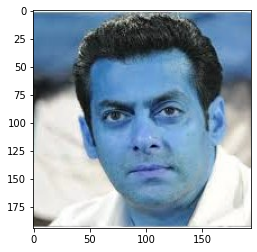

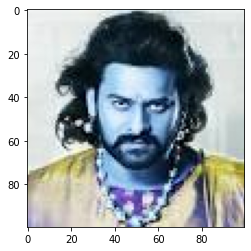

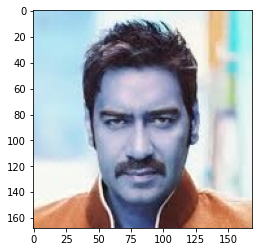

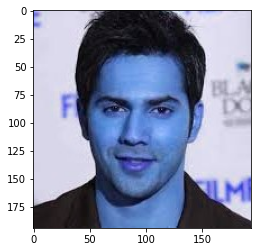

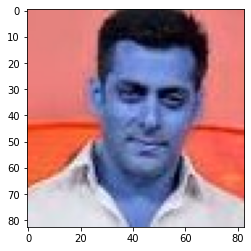

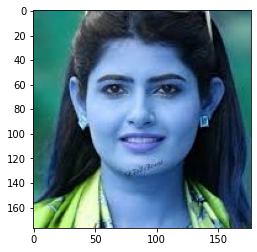

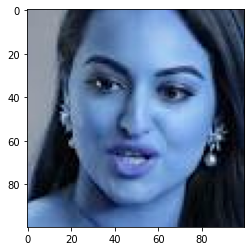

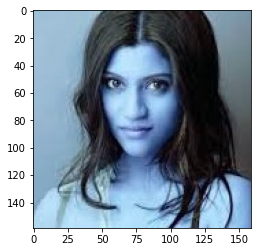

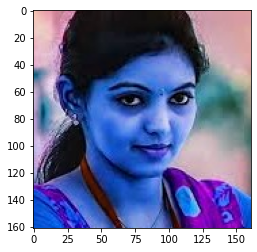

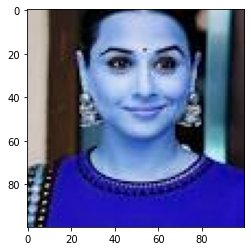

In [4]:
import matplotlib.image as mpimg
for i in images_short[0:10]:
    plt.imshow(i)
    plt.show()

<b>Resizing the image to 150*150 with three channels</b>

In [5]:
nrows = 150
ncolumns = 150
nchannels = 3
resized_images_short = []
for i in images_short:
    resized_images_short.append(cv2.resize(i, (nrows,ncolumns) , interpolation = cv2.INTER_CUBIC))
resized_images_long = []
for i in images_long:
    resized_images_long.append(cv2.resize(i, (nrows,ncolumns) , interpolation = cv2.INTER_CUBIC))

<b>Checking a sample of the images after resizing</b>

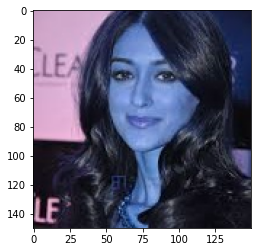

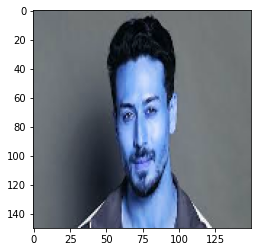

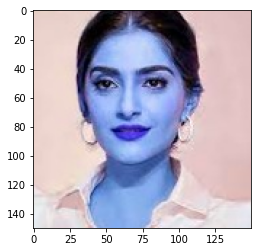

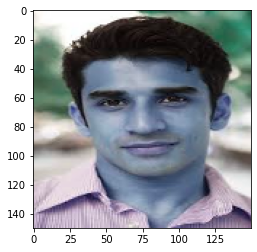

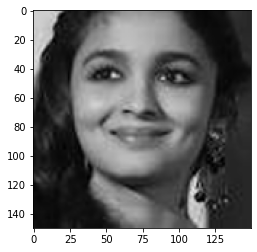

In [6]:
for i in range(5):
    plt.imshow(resized_images_long[i])
    plt.show()

<b>Creating corresponding class labels</b>

In [8]:
labels_short = []
for i in range(len(resized_images_short)):
    labels_short.append(1)
labels_long = []
for i in range(len(resized_images_long)):
    labels_long.append(0)

<b>Appending the lists of resized images and labels from both the classes in a synchronised order</b>

In [9]:
for i in resized_images_long:
    resized_images_short.append(i)
for i in labels_long:
    labels_short.append(i)

<b>Assigning the image data and the labels to the variables X and y respectively</b>

In [10]:
X = np.array(resized_images_short)
y = np.array(labels_short)

<b>Visualizing the count of classes</b>

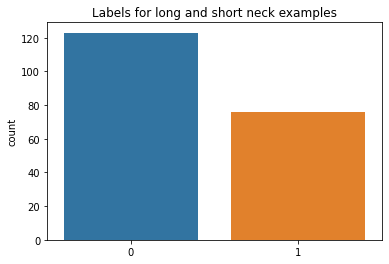

In [11]:
import seaborn as sns
plt.title('Labels for long and short neck examples')
ax = sns.countplot(y)

<b>Finding the shape of images and the labels<b>

In [12]:
print('Shape of images is', X.shape)
print('Shape of labels is', y.shape)

Shape of images is (199, 150, 150, 3)
Shape of labels is (199,)


<b>Performing train-test split & assigning number of training, test examples and the batch size to variables</b>

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print('\n', 'X_train :', X_train.shape, '\n','X_test :', X_test.shape, '\n'
      , 'X_train :', y_train.shape, '\n', 'y_test :', y_test.shape)
ntrain = len(X_train)
ntest = len(X_test)
batch_size = 32


 X_train : (139, 150, 150, 3) 
 X_test : (60, 150, 150, 3) 
 X_train : (139,) 
 y_test : (60,)


<b>Defining the network architecture 32 → 64 → 128 → 512 → 1</b>

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

<b>Checking the model summary</b>

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

<b>Compiling the model with log-loss as the cost functionn RMSprop as the optimizer and accuracy as the performance metrix</b>

In [32]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4) , metrics = ['acc'])

<b>Decoding images , converting to tensors and performing augmentation</b>

In [33]:
training_datagen = ImageDataGenerator(rescale = 1/255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2, 
                                     height_shift_range = 0.2,
                                     shear_range = 0.2, 
                                     zoom_range = 0.2, 
                                     horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1/255)

<b>Defining train and test generators</b>

In [34]:
train_generator = training_datagen.flow(X_train, y_train, batch_size = batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size = batch_size)

<b>Fitting and Validating the model</b>

In [35]:
history = model.fit_generator(train_generator, 
                             steps_per_epoch = ntrain, 
                             epochs = 64, 
                             validation_data = test_generator, 
                             validation_steps = ntest)

Epoch 1/64
139/139 [==============================] - 118s 847ms/step - loss: 0.6760 - acc: 0.5952 - val_loss: 0.6511 - val_acc: 0.6667
Epoch 2/64
139/139 [==============================] - 113s 810ms/step - loss: 0.6552 - acc: 0.6111 - val_loss: 0.7334 - val_acc: 0.6667
Epoch 3/64
139/139 [==============================] - 112s 807ms/step - loss: 0.6251 - acc: 0.6545 - val_loss: 0.6039 - val_acc: 0.7500
Epoch 4/64
139/139 [==============================] - 112s 807ms/step - loss: 0.5895 - acc: 0.6977 - val_loss: 0.5259 - val_acc: 0.7333
Epoch 5/64
139/139 [==============================] - 113s 811ms/step - loss: 0.5561 - acc: 0.7199 - val_loss: 0.3856 - val_acc: 0.7000
Epoch 6/64
139/139 [==============================] - 112s 804ms/step - loss: 0.5358 - acc: 0.7337 - val_loss: 0.5932 - val_acc: 0.7333
Epoch 7/64
139/139 [==============================] - 112s 803ms/step - loss: 0.5251 - acc: 0.7487 - val_loss: 0.6699 - val_acc: 0.6833
Epoch 8/64
139/139 [============================

Epoch 61/64
139/139 [==============================] - 115s 827ms/step - loss: 0.0484 - acc: 0.9821 - val_loss: 2.7116 - val_acc: 0.6000
Epoch 62/64
139/139 [==============================] - 2325s 17s/step - loss: 0.0427 - acc: 0.9838 - val_loss: 2.7829 - val_acc: 0.7000
Epoch 63/64
139/139 [==============================] - 111s 801ms/step - loss: 0.0503 - acc: 0.9823 - val_loss: 2.4219 - val_acc: 0.6500
Epoch 64/64
139/139 [==============================] - 113s 810ms/step - loss: 0.0538 - acc: 0.9817 - val_loss: 1.8332 - val_acc: 0.6333


In [36]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [41]:
acc = history.history['acc']
test_acc = history.history['val_acc']
loss = history.history['loss']
test_loss = history.history['val_loss']

In [39]:
epochs = range(1, len(acc) +1)

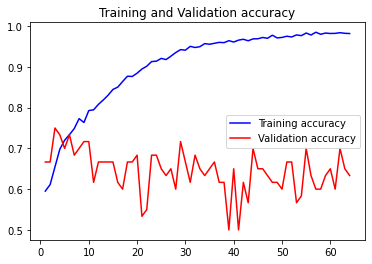

In [44]:
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, test_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

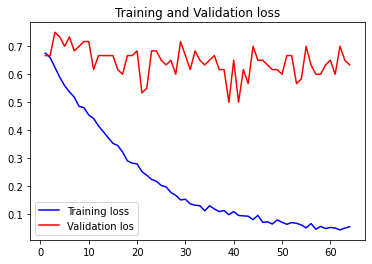

In [46]:
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, test_acc, 'r', label = 'Validation los')
plt.title('Training and Validation loss')
plt.legend()